In [2]:

import numpy as np

n=12
G=6
S=3
T=3
C=1
P=10


# task type 0: POTRF 1:SYRK 2:TRSM 3: GEMMS
# all have 4 values, but the last one is used for GEMMS only (-;
# a task is a 4-uple and everything will be stored in dictionnaries later
# succalap is the set of successors in the alap schedule, ie the predecessors in the original graph

def succALAP(x):
    tasktype=x[0]
    i=x[1]
    j=x[2]
    k=x[3]
    listsucc=[]
    if tasktype==0:
        if i>1:
            y=(1,i,i-1,0)
            listsucc.append(y)
        else:
            y=(4,0,0,0)
            listsucc.append(y)            
    if tasktype==1:
        if j >=2:
            y=(1,i,j-1,0)
            listsucc.append(y)
        y=(2,j,i,0)
        listsucc.append(y)       
    if tasktype==2:
        y=(0,i,0,0)
        listsucc.append(y)
        if i>1:
            y=(3,i,j,i-1)
            listsucc.append(y)
    if tasktype==3:
        if k>1:
            y=(3,i,j,k-1)
            listsucc.append(y)
        y=(2,k,j,0) 
        listsucc.append(y)
        y=(2,k,i,0) 
        listsucc.append(y)

    return listsucc


# duration is just the duration of a task

def duration(x):
    tasktype=x[0]
    if tasktype==0:
        duration=C
    if tasktype==1:
        duration=S        
    if tasktype==2:
        duration=T
    if tasktype==3:
        duration=G
    return duration

durations = [C, S, T, G]

print(succALAP((2,3,0,0)))
#print(succALAP((0,n,0,0)))
#print(succALAP((1,5,4,0)))
#print(succALAP((2,4,5,0)))
#print(succALAP((3,5,6,3)))


[(0, 3, 0, 0), (3, 3, 0, 2)]


In [5]:
maxi=(G+T+S+C)*n*n*n
mini=-1


#ReadyTasks is the set of tasks that are ready to be processed (all their predecessors have been processed)
# due to limited resources, they might be waiting for resources
ReadyTasks=[]
ReadyTasks.append((0,n,0,0))


#Ltasks is the list of tasks that have not been processed and that are not yet ready
LTasks=[]

#disctionnary Processed provides, for each task, where and when it has been processed
Processed={}
#dictionnary Released provides, for each task, the minimum time when it can be processed (-1 at the beginning), 
# given its already scheduled predecessors. The number of remaining predecessors to be 
# scheduled is stored in NbSuccASAP={}
Released={}
NbSuccASAP={}
# Prio is the priority of the task for the alap.
# at the moment, Prio is just the length of the critical path in ASAP (because I had the values at hand !)
Prio={}

CP=2*C+T+S+(n-2)*(T+G)

Released[(0,n,0,0)]=mini
NbSuccASAP[(0,n,0,0)]=0
Prio[(0,n,0,0)]=0

# initialization of Prio (critical path in ASAP), Released (-1 at the beginning), 
# NbSuccASAP (predecessors in ALAP) 

for i in range(1,n):
    Released[(0,i,0,0)]=mini
    Prio[(0,i,0,0)]=CP-(i-1)*(T+G)
#    Prio[(0,i,0,0)]=n-i
#    Prio[(0,i,0,0)]=i

    NbSuccASAP[(0,i,0,0)]=n-i
    LTasks.append((0,i,0,0))



for j in range(1,n):
    for i in range(j+1,n+1):
        Released[(1,i,j,0)]=mini
        NbSuccASAP[(1,i,j,0)]=1
        LTasks.append((1,i,j,0))
        if i < n:
            Prio[(1,i,j,0)]=CP-(i-1)*(T+G)+(i-j)*S
 #           Prio[(1,i,j,0)]=n-j
#            Prio[(1,i,j,0)]=j



        else:
            Prio[(1,i,j,0)]=C+(n-j)*S 
#            Prio[(1,i,j,0)]=n-j 
#            Prio[(1,i,j,0)]=j 


for i in range(1,n):
    for j in range(i+1,n+1):
        LTasks.append((2,i,j,0))
        Released[(2,i,j,0)]=mini
        Prio[(2,i,j,0)]=CP-C-(i-1)*(T+G)
#        Prio[(2,i,j,0)]=n-i
#        Prio[(2,i,j,0)]=i


        NbSuccASAP[(2,i,j,0)]=n-i




for k in range(1,n-1):
    for i in range(k+1,n):
        for j in range(i+1,n+1):
            LTasks.append((3,i,j,k))
            Released[(3,i,j,k)]=mini
            Prio[(3,i,j,k)]=CP-C+G+T-i*T-k*G
 #           Prio[(3,i,j,k)]=n-k
#            Prio[(3,i,j,k)]=k
            NbSuccASAP[(3,i,j,k)]=1




            
#ProcReady[i] is the time when processor P_i is available.

ProcReady=[0]*P



# instant represents the current time
instant=0



while len(ReadyTasks)>0:

    for i in range(P):
        ProcReady[i]=max(instant,ProcReady[i])
    print('debut',"\n",instant)
    print('ReadyTasks',ReadyTasks)
    print("Processed",Processed)
    print('ProcReady',ProcReady,"\n\n\n")

#indices is the list of the processors that are ready the soonest
    indices = [i for i, x in enumerate(ProcReady) if x == min(ProcReady)]
        
#nextinstant1 is the next instant when something can happen         
    nextinstant1=maxi

    for i in indices:
        # first find the highest priority task among the ready ones
        if len(ReadyTasks)>0:
            HighestPrio=maxi
            for task in ReadyTasks:
                if Prio[task] <= HighestPrio:
                    HighestPrio = Prio[task]
                    HPTask=task
            #mark all its successors with one depedendency less        
            for task in succALAP(HPTask):
                Released[task]=max(Released[task],ProcReady[i]+duration(HPTask))
                NbSuccASAP[task]=NbSuccASAP[task]-1

        #mark the task processed, update the availability of the associated proc and remove it from some lists    
            ProcReady[i]=max(ProcReady[i],instant)+duration(HPTask)
            Processed[HPTask]=[i,ProcReady[i]]
            ReadyTasks.remove(HPTask)
            del Released[HPTask]
        #mininstant1 is the next instant when a busy processor will be released

    nextinstant=maxi

    # if there are no more ready tasks, we should determine the time when something will happen
    # ie a task that is not ready yet but will become soon given what has been scheduled (ie no dependencies
    # but still running predecessors)
    # in this first part, the goal is to find the first instant when a task will become ready
    if len(ReadyTasks)==0:
        for task in LTasks:
            if task not in ReadyTasks:
                if NbSuccASAP[task] ==0:
                    if task in Released:
                        if Released[task] <= nextinstant:
                            nextinstant=min(nextinstant,Released[task])
    else:
        nextinstant=min(ProcReady)

   # once we now this instant (nextinstant) just put the corresponding task(s) into the ready list                       
    if len(ReadyTasks)==0:
        for task in LTasks:
            if task not in ReadyTasks:
                if NbSuccASAP[task] ==0:
                    if task in Released:
                        if Released[task] <= nextinstant:                       
                            ReadyTasks.append(task)

    
    #and advance the time until the new instant when something will happen (and in particlar there
    #should be a ready task)


    instant=nextinstant


    
    
    if (0,1,0,0) in ReadyTasks:
        #we reached the first POTRF
        break


        
Processed[(0,1,0,0)]=[0,max(ProcReady)+C]  

print(Processed)
print("CP=",CP,"endtime=",max(ProcReady)+C)
            
            

debut 
 0
ReadyTasks [(0, 12, 0, 0)]
Processed {}
ProcReady [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 



debut 
 1
ReadyTasks [(1, 12, 11, 0)]
Processed {(0, 12, 0, 0): [0, 1]}
ProcReady [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 



debut 
 4
ReadyTasks [(1, 12, 10, 0), (2, 11, 12, 0)]
Processed {(0, 12, 0, 0): [0, 1], (1, 12, 11, 0): [0, 4]}
ProcReady [4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 



debut 
 7
ReadyTasks [(0, 11, 0, 0), (1, 12, 9, 0), (3, 11, 12, 10)]
Processed {(0, 12, 0, 0): [0, 1], (1, 12, 11, 0): [0, 4], (2, 11, 12, 0): [0, 7], (1, 12, 10, 0): [1, 7]}
ProcReady [7, 7, 7, 7, 7, 7, 7, 7, 7, 7] 



debut 
 8
ReadyTasks [(1, 11, 10, 0)]
Processed {(0, 12, 0, 0): [0, 1], (1, 12, 11, 0): [0, 4], (2, 11, 12, 0): [0, 7], (1, 12, 10, 0): [1, 7], (0, 11, 0, 0): [0, 8], (1, 12, 9, 0): [1, 10], (3, 11, 12, 10): [2, 13]}
ProcReady [8, 10, 13, 8, 8, 8, 8, 8, 8, 8] 



debut 
 10
ReadyTasks [(1, 12, 8, 0)]
Processed {(0, 12, 0, 0): [0, 1], (1, 12, 11, 0): [0, 4], (2, 11, 12, 0): [0, 7], (1, 12, 10, 0): [1, 7], (0,

In [6]:



def nbgemms(d):

    dg = (n-2)*G+C+S + T
    if d <= dg:
        B1= 1 / (2*(G + T)*(G+T))
        C1= (3*G+T - 2*C-2*S)/ (2*(G + T)*(G+T))
        D1= ((G- C-S)*(2*G+T -C-S)) / (2*(G + T)*(G+T))
        nbgemm = B1*d*d+C1*d+D1
        
    elif d <= CP-C-T:
        B2= 1/(2*(G+T)*(G+T))-1/(2*T*T)
        #C2= 2/(T+G) -(C+S+T)/((T+G)*(T+G))+((n-2)*G+C+S)/(T*T)
        C2= 1/2/(T+G) + 1/(2*T) -(C+S-G)/((T+G)*(T+G))+((n-2)*G+C+S)/(T*T)
        #D2= 2- 2*(C+S+T)/(T+G)+ ((C+S+T)*(C+S+T))/(2*(G + T)*(G+T)) - ((n-2)*G+C+S)*((n-2)*G+C+S)/(2*T*T)
        D2= 1-(C+S+T)/(2*(T+G))+ ((C+S-G)*(C+S-G))/(2*(G + T)*(G+T)) - ((n-2)*G+C+S)*((n-2)*G+C+S)/(2*T*T)-((n-2)*G + C+S)/(2*T)
        nbgemm = B2*d*d+C2*d+D2
    else:
        nbgemm=0
    return(nbgemm)

    
    
def nbtrsms(d):
    C1=1/(T+G)
    D1=(G-S -C)/(T+G)
    nbtrsm= C1*d+D1
    return(np.ceil(nbtrsm))

def nbsyrks(d):
    ds = (n-1)*S+2*C+T
    #ds = n*S -G +2*C
    if d <= ds:
        C1=1/(T+G)
        D1=(G-2*C-S)/(T+G)
        nbsyrk = d*C1+D1
    else:
        D2 = S*((n-1)*(T +G)-G+2*C +S)/((T +G)*(T +G-S)) + 1
        C2 = -S / ((T +G)*(T +G-S))
        nbsyrk = C2*d+D2
    if d <=(n-1)*S + C:
        nbsyrk += 1
    return(nbsyrk) 


def nbpotrfs(d):
    nbpotrf= 1
    return(nbpotrf)


def nbtot(d):
    return (nbpotrfs(d)+nbsyrks(d)+nbgemms(d)+nbtrsms(d))


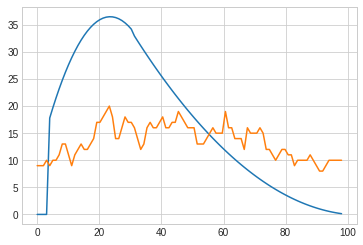

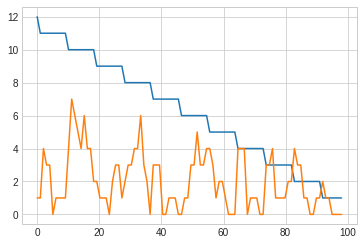

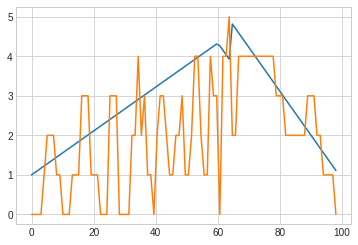

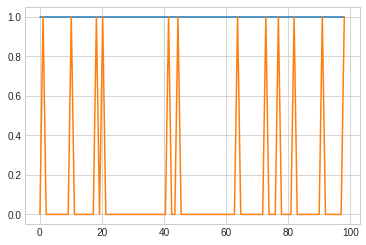

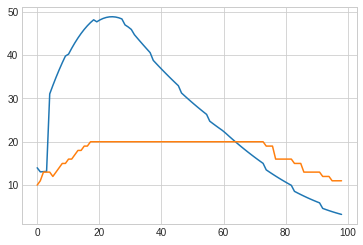

In [8]:

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np


nbg=[0]*CP
nbs=[0]*CP
nbt=[0]*CP
nbc=[0]*CP
nbtot=[0]*CP


for key, value in Processed.items():
    for i in range(duration(key)):
        if key[0]==0: 
            nbc[CP-(value[1]-i)]=nbc[CP-(value[1]-i)]+1
        if key[0]==1: 
            nbs[CP-(value[1]-i)]=nbs[CP-(value[1]-i)]+1        
        if key[0]==2: 
            nbt[CP-(value[1]-i)]=nbt[CP-(value[1]-i)]+1
        if key[0]==3: 
            nbg[CP-(value[1]-i)]=nbg[CP-(value[1]-i)]+1

for i in range(len(nbg)):
    nbtot[i]=nbg[i]+nbt[i]+nbs[i]+nbc[i]

fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, CP, CP )
yg=[]
yt=[]
yc=[]
ys=[]
ytot=[]


for val in x:
    yg.append(nbgemms(CP-val)) 
    yt.append(nbtrsms(CP-val)) 
    yc.append(nbpotrfs(CP-val)) 
    ys.append(nbsyrks(CP-val)) 
    ytot.append(nbgemms(CP-val)+nbtrsms(CP-val)+nbpotrfs(CP-val)+nbsyrks(CP-val))
    
ax.plot(x, yg);
ax.plot(x, nbg);

fig = plt.figure()
ax = plt.axes()
ax.plot(x, yt);
ax.plot(x, nbt);


fig = plt.figure()
ax = plt.axes()
ax.plot(x, ys);
ax.plot(x, nbs);

fig = plt.figure()
ax = plt.axes()
ax.plot(x, yc);
ax.plot(x, nbc);


fig = plt.figure()
ax = plt.axes()
ax.plot(x, ytot);
ax.plot(x, nbtot);



#ax.plot(x, yt);
#ax.plot(x, yc);
#ax.plot(x, ys);













In [9]:
print(CP)

98


In [10]:
import numpy as np

def start_time(time, makespan):
    return makespan - time
    
def get_data(Processed):
    #makespan should be dicrete and durations should be discretized
    makespan = Processed[(0,1,0,0)][1]
    current_times = [[makespan]*P]
    data = np.ones((P, makespan)) * (-1)
    compl_data = [[] for _ in range(P)]
    #data = [[]*P]
    for x, sched in Processed.items():
        tasktype = x[0]
        pr = sched[0]
        s_time = start_time(sched[1], makespan)
        e_time = s_time + duration(x)
        data[pr, s_time:e_time] = tasktype
        #print('process', pr)
        if tasktype == 0:
            compl_data[pr].insert(0, (x[1]))
        elif tasktype == 1:
            compl_data[pr].insert(0, (x[1], x[2]))
        elif tasktype == 2:
            compl_data[pr].insert(0, (x[1], x[2]))
        else:
            compl_data[pr].insert(0, (x[1], x[2], x[3]))
        #print('here', len(compl_data[0]), len(compl_data[1]), len(compl_data[2]), len(compl_data[3]))

    return data, compl_data
    

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_schedule(Processed, figsize = (80,30), fig_file = None, flip = True):
    data, compl_data = get_data(Processed)
    if flip:
        data = data[-1::-1, :]
        compl_data = compl_data[-1::-1]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_aspect(1)

    def avg(a, b):
        return (a + b) / 2.0

    for y, row in enumerate(data):
        #for x, col in enumerate(row):
        x = 0
        i = 0
        indices_in_row = compl_data[y]
        while x < len(row): 
            col = row[x]
            if col != -1:
                shift = durations[int(col)]
                indices = indices_in_row[i]
            else: 
                x = x + 1
                continue
            x1 = [x, x+shift]
            y1 = np.array([y, y])
            y2 = y1+1
            if col == 0:
                plt.fill_between(x1, y1, y2 = y2, facecolor= 'green', edgecolor = 'Black')
                plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), 'C({})'.format(indices), 
                                            horizontalalignment = 'center',
                                            verticalalignment = 'center')

            if col == 1:
                plt.fill_between(x1, y1, y2=y2, facecolor='red', edgecolor = 'Black')
                plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), "S{}".format(indices), 
                                            horizontalalignment='center',
                                            verticalalignment='center')
            if col == 2:
                plt.fill_between(x1, y1, y2=y2, facecolor='orange', edgecolor = 'Black')
                plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), "T{}".format(indices), 
                                            horizontalalignment='center',
                                            verticalalignment='center')
            if col == 3:
                plt.fill_between(x1, y1, y2=y2, facecolor='yellow', edgecolor = 'Black')
                plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), "G{}".format(indices), 
                                            horizontalalignment='center',
                                            verticalalignment='center')
            x = x + shift
            i = i + 1

    plt.ylim(P, 0)
    plt.xlim(-1e-3, data.shape[1] + 1e-3)
    if fig_file != None:
        plt.savefig(fig_file)
    return

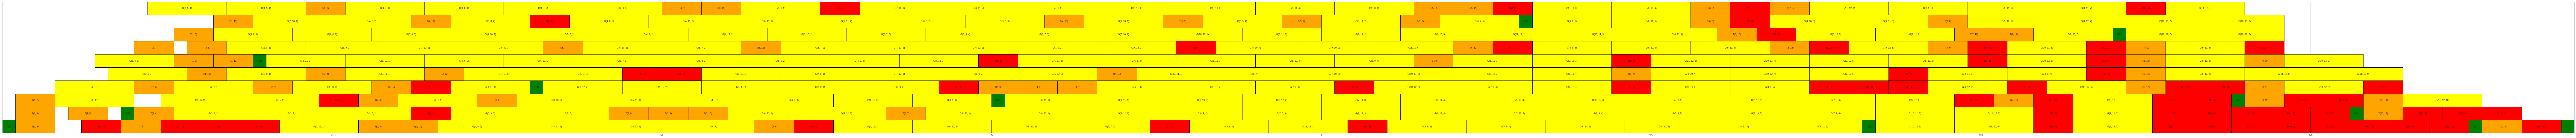

In [17]:
visualize_schedule(Processed, figsize=(200, 100),fig_file = 'sched_p13.png')